# PART 1  --  Predicting Airfare Price

> * import modules

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as prf_score
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from datetime import datetime 
import requests
import pickle
import time

import matplotlib.pylab as pylab

from matplotlib.ticker import MaxNLocator

params = {'legend.fontsize': 'x-large',
          'font.size': 10,
          'figure.figsize': (17, 3),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}
pylab.rcParams.update(params)

In [2]:
import sys
print(sys.executable)

/home/aind2/anaconda3/envs/aind-dog/bin/python


> * Load `csv` files from disk

In [3]:
# TAKES ~15 SECS TO LOAD THE DATA.
start = time.time()

airport_data = pd.read_csv('airport_data.csv')
booking_data = pd.read_csv('booking_data.csv')
search_data = pd.read_csv('search_data.csv')

end = time.time()
print('Runtime: %d min %d sec' % ((end-start)//60, (end-start)%60))

/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Runtime: 0 min 10 sec


> Some useful functions, for 
* automatic online currency conversion, 
* approximating the distance between two airports, 
* approximating the missing lattitude and longitude values by averaging the locations of nearby airports in airport_data.csv
* computing the `'distance'` feature to be used in the Linear Regression Model.

In [4]:
# Runtime for creating the currency convertion rates dictionary = 1 MIN 32 SEC. len(rates) = 114.
# Once created, pickle it to "rates.pkl"
# Next time you run the cell, load "rates" from "rates.pkl".

start = time.time()

def print_runtime():
    end = time.time()
    print('Runtime: %d min %d sec' % ((end-start)//60, (end-start)%60))
    
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

def get_all_currencies():
    gr1 = search_data.groupby('currency')
    gr2 = booking_data.groupby('currency')
    s1 = set(gr1.groups.keys())
    s2 = set(gr2.groups.keys())
    return s1.union(s2)


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

def get_conversion_rates():
    import requests
    
    rates = dict()
    for ccc in get_all_currencies():
        url = 'http://www.xe.com/currencyconverter/convert/?Amount=1&From=%s&To=USD' % (ccc) 
        r = requests.get(url) 
        rates[ccc] = float(r.text.split('uccResultAmount')[1].split('span')[0][2:-2])
        print("from:%s to:USD --- rate:%10.7f" % (ccc, rates[ccc]))
        
    return rates

def convert_fare_currency(df, booking_time, rates):
    df[booking_time] = pd.to_datetime(df[booking_time])
    df['currency'] = df['currency'].map(lambda s: s.upper())
    curr = df['currency'].values.astype(type('string_type'))
    fare = df['fare'].values

    fare_USD = np.zeros(len(fare)) # initialize
    
    for i, token in enumerate(zip(fare,curr)):
        fare_USD[i] = token[0] * rates[token[1]]
    return fare_USD

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

def get_dict_airport():
    dict_airport = {}
    gr = airport_data.groupby('iata_code')

    for k, rowlabel in gr.groups.items():
        vals = airport_data.iloc[rowlabel][['latitude', 'longitude']].values[0]
        dict_airport[k] = vals
    return dict_airport

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


def haversine_distance(tup1, tup2):
    from math import sin, cos, sqrt, atan2, radians, acos, pi, asin
    
    lat1, lon1 = tup1
    lat2, lon2 = tup2
    
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

def add_distance_column(booking_data):
    origin = booking_data['origin']
    destination = booking_data['destination']
    distance = np.zeros(len(booking_data))
    for i, token in enumerate(zip(origin, destination)):
        try:
            distance[i] = haversine_distance(dict_airport[token[0]], dict_airport[token[1]])
        except:
            distance[i] = None

    booking_data['distance'] = distance
    booking_data['distance'].replace(np.nan, booking_data['distance'].mean(), inplace=True)
    
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
#
# pre-processing airport_data 
# fill in the latitude and longitude NaN's, with country averages.

def nan_fill_airport():
    for ix in airport_data.index:    
        if np.isnan(airport_data.loc[ix, 'latitude']):
            df = airport_data[airport_data['country'] == airport_data.loc[ix,'country']] 
            lat_mean = df['latitude'].mean()
            lon_mean = df['longitude'].mean()
            airport_data.loc[ix, 'latitude'] = lat_mean
            airport_data.loc[ix, 'longitude'] = lon_mean
        

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


def plotter(xlabel=None, ylabel=None, title=None, xlim=None, ylim=None):
    fig = plt.figure()
    ax = plt.gca()
    fig.set_size_inches((15,5))
    plt.grid('on')
    if xlabel: plt.xlabel(xlabel)
    if ylabel: plt.ylabel(ylabel)
    if xlim: plt.xlim((0, xlim));
    if ylim: plt.ylim((0, ylim));
    if title: plt.title(title)
    return fig, ax

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


# 1.
# rates = get_conversion_rates()
# with open('rates.pkl', 'wb') as f:
#     pickle.dump(rates, f, pickle.HIGHEST_PROTOCOL)
with open('rates.pkl', 'rb') as f:
    rates = pickle.load(f)
    
# 2.
nan_fill_airport()

# 3.
dict_airport = get_dict_airport()

# 4.
add_distance_column(booking_data)
add_distance_column(search_data)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
print_runtime()

Runtime: 0 min 13 sec


> * Cleaning up data ...............................

In [5]:
# There are 68 rows with booking_data['passengers'] = 0
# Replace them with the mean 1.78
booking_data.loc[booking_data['passengers'] == 0, 'passengers'] = booking_data['passengers'].mean()
search_data.loc[search_data['passengers'] == 0, 'passengers'] = search_data['passengers'].mean()
#
# 
# 
booking_data['cabin_class'] = booking_data['cabin_class'].map(lambda x: x.upper())
booking_data['language']    = booking_data['language'].map(lambda x: x.upper())
search_data['cabin_class']  = search_data['cabin_class'].map(lambda x: x.upper())
search_data['language']     = search_data['language'].map(lambda x: x.upper())


In [6]:
print("booking_data.shape = {}, {}".format(*(booking_data.shape)))
print("search_data.shape =  {}, {}".format(*(search_data.shape)))

booking_data['fare_USD'] = convert_fare_currency(booking_data, 'booking_time', rates)
search_data['fare_USD'] = convert_fare_currency(search_data, 'search_time', rates)

# normalize 'fare_USD' by number of persons on the purchase.
booking_data['fare_USD'] = booking_data['fare_USD'] / booking_data['passengers']
search_data['fare_USD'] = search_data['fare_USD'] / search_data['passengers']

booking_data.shape = 16854, 26
search_data.shape =  1277062, 26


> * Filter out the rows that have over $50,000 fare_USD values. These unreasonable prices might be inaccurate records in the data.

In [7]:
mask1 = np.logical_and(booking_data['fare_USD'] > 0, booking_data['fare_USD'] < 50000)
mask2 = np.logical_and(search_data['fare_USD'] > 0, search_data['fare_USD'] < 50000)

booking_data = booking_data[mask1]
search_data = search_data[mask2]

> * Create various powers of `'distance'` feature and normalize each of them separately with their standard deviations.

In [8]:
def create_nonlinear_features(df):
    # create some non-linear features on 'distance'
    df['distance_n'] = (df['distance'])/df['distance'].std()
    df['distance_n0p5'] = df['distance_n'] ** 0.5
    df['distance_n1p5'] = df['distance_n'] ** 1.5
    df['distance_n2'] = df['distance_n'] ** 2
    df['distance_n3'] = df['distance_n'] ** 3
    df['distance_n4'] = df['distance_n'] ** 4
    
    # Now, normalize them 
    df['distance_n0p5'] = df['distance_n0p5']/df['distance_n0p5'].std()
    df['distance_n1p5'] = df['distance_n1p5']/df['distance_n1p5'].std()
    df['distance_n2'] = df['distance_n2']/df['distance_n2'].std()
    df['distance_n3'] = df['distance_n3']/df['distance_n3'].std()
    df['distance_n4'] = df['distance_n4']/df['distance_n4'].std()
    # df['fare_USD'] = df['fare_USD']/df['fare_USD'].std()

# # # # # # # # # 
# # # # # # # # # 

create_nonlinear_features(search_data)
create_nonlinear_features(booking_data)
print("booking_data.shape : %i\n search_data.shape : %i " % (booking_data.shape[0], search_data.shape[0]))

booking_data.shape : 16853
 search_data.shape : 1277010 


> * Fix the typos in `'cabin_class'` category and consolidate them into 5 main categories.

In [9]:
booking_data['cabin_class'].replace(
    {'PREMIUM ECONOMY': 'PREMIUM_ECONOMY', 
     'FIRST': 'FIRST_CLASS', 
     'FIRST CLASS':'FIRST_CLASS',
     'COACH':'ECONOMY'},
    inplace=True)

search_data['cabin_class'] = search_data['cabin_class'].map(lambda x: x.upper())

search_data['cabin_class'].unique()
search_data['cabin_class'].replace(
    {'COACH': 'ECONOMY',
     'FIRST': 'FIRST_CLASS',
     'PREMIUM ECONOMY': 'PREMIUM_ECONOMY',
     'PREMIUMECONOMY' : 'PREMIUM_ECONOMY',
     'FIRST CLASS': 'FIRST_CLASS'
    },
inplace=True)


# print(booking_data['cabin_class'].unique())
# print('')
# print(search_data['cabin_class'].unique())


> * Create one-hot-encoding for the categorical feature `'cabin_class'` with `pd.get_dummies`, even though they will only be used to separate the training data set and not be used directly in the model.

In [10]:
# DON'T RUN THIS CELL MORE THAN ONCE !!!
# GET_DUMMIES CELL

df_train1 = pd.get_dummies(booking_data, columns=['cabin_class']) 
df_train2 = pd.get_dummies(search_data, columns=['cabin_class']) 

categorical_features = []
for cn in df_train2.columns:
    if cn[:12] == 'cabin_class_':
        categorical_features.append(cn)

booking_data[categorical_features] = df_train1[categorical_features]
search_data[categorical_features]  = df_train2[categorical_features]

# order 'categorical_features' ...
# categorical_features = [
#  'cabin_class_ECONOMY',
#  'cabin_class_PREMIUM_ECONOMY',
#  'cabin_class_BUSINESS',
#  'cabin_class_FIRST_CLASS',
#  'cabin_class_MIXED']

# order 'categorical_features' them in increasing comfort class
categorical_features = [categorical_features[i] for i in [1,4,0,2,3]]
print(categorical_features)

['cabin_class_ECONOMY', 'cabin_class_PREMIUM_ECONOMY', 'cabin_class_BUSINESS', 'cabin_class_FIRST_CLASS', 'cabin_class_MIXED']


> * Histogram of `'distance'` for both `search_data` and `booking_data` look similar.

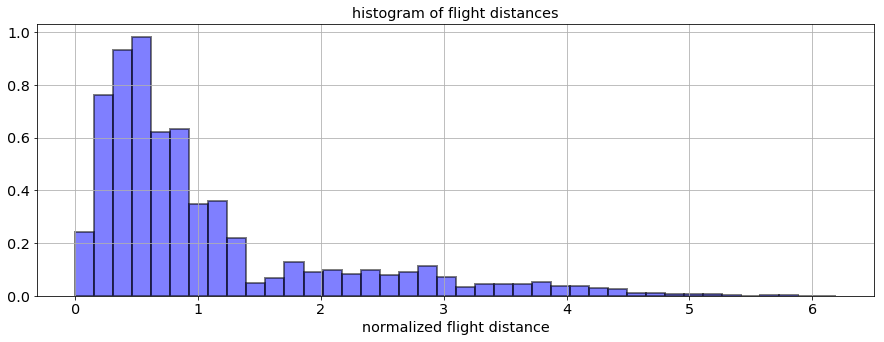

In [11]:
fig, ax = plotter(xlabel='normalized flight distance', title='histogram of flight distances')
plt.hist(search_data['distance_n'], bins=40, edgecolor='black' , linewidth=2,
        color='b', normed=True, alpha=.5);

> * Histogram of `'fare_USD'` from `booking_data.csv`.
> * It's observed that the booking fares are cheaper than the searched fares.

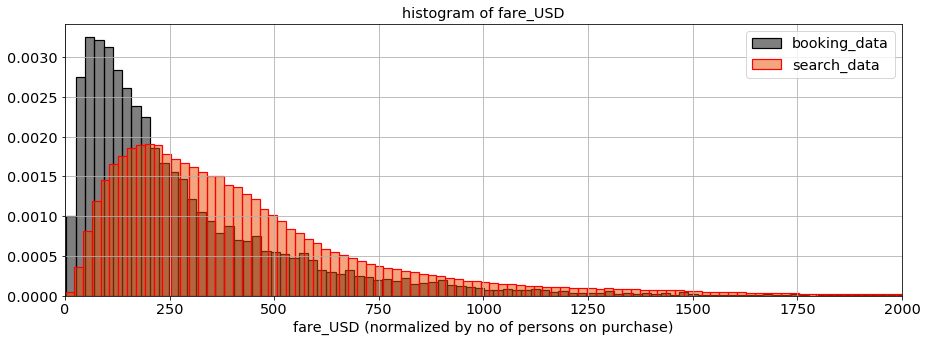

In [12]:
fig, ax = plotter(xlabel='fare_USD (normalized by no of persons on purchase)', title='histogram of fare_USD')
ax.hist(booking_data[booking_data['cabin_class']=='ECONOMY']['fare_USD'], 
        bins=1000, edgecolor='black', lw=1.2, 
        normed=True, fc=(0, 0, 0, 0.5));

ax.hist(search_data[search_data['cabin_class']=='ECONOMY']['fare_USD'], 
        bins=2000, edgecolor='red', lw=1.2,
        normed=True, fc=(.9, .3, 0, 0.5));

plt.legend(['booking_data', 'search_data']);
ax.set_xlim((0,2000));

> * There are 5 `'cabin_class'` categories. In both `booking_data.csv` and `search_data.csv`. 
> * Approximately, 98-99% of the customers who have a record in `'book_data.csv'` also have records in `'search_data.csv'`

In [13]:
for colname in categorical_features:
    print('%s : %i' % (colname, len(search_data[search_data[colname] == 1])))

cabin_class_ECONOMY : 1253082
cabin_class_PREMIUM_ECONOMY : 1568
cabin_class_BUSINESS : 3102
cabin_class_FIRST_CLASS : 2610
cabin_class_MIXED : 16648


>* Choose the features and the target, then load them into `np.arrays`: `X` and `y`.      
* Train the Linear Model, and print the score $R^2$.   
* $R^2$ is the percent variance explained by the model. $R^2 \leq 1$ but it could also be negative due to severe over or underfitting.

In [14]:
def choose_features(df, cabin_class_index):
    print('%s'%  categorical_features[cabin_class_index][12:])
    mask = df[categorical_features[cabin_class_index]] == 1
    # mask = [True]*len(df)
   
    features = ['distance_n0p5', 'distance_n']
    X, y = df[mask][features].values, df[mask]['fare_USD'].values
    return X, y

# # # # # # # # # # # # # # #
# # # # # # # # # # # # # # #

X, y = choose_features(search_data, cabin_class_index=0) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)


reg = LinearRegression()
reg.fit(X_train, y_train)

print('')
print('R^2 score (TRAINING set (%i datapoints)): %5.3f' % (len(X_train), reg.score(X_train, y_train)))
print('R^2 score (TEST set     (%i datapoints)): %5.3f' % (len(X_test),  reg.score(X_test,  y_test)))


ECONOMY

R^2 score (TRAINING set (1002465 datapoints)): 0.295
R^2 score (TEST set     (250617 datapoints)): 0.283


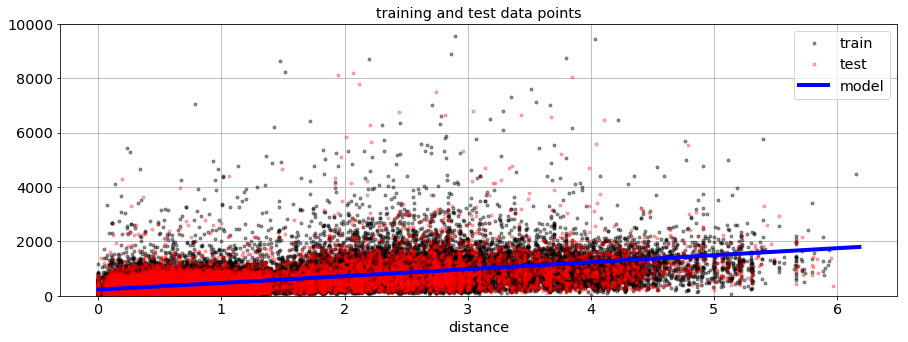

In [15]:
df1 = booking_data.copy()
df2 = search_data.copy()

xb = np.arange(0, max(X[:,1]),.03)
yb = np.column_stack((xb**.5, xb)).dot(reg.coef_) + reg.intercept_

fig, ax = plotter(title='training and test data points', xlabel='distance')

d_ = 10
pick1 = sorted(np.random.choice(range(len(X_train)), len(X_train)//d_ , replace=False))
pick3 = sorted(np.random.choice(range(len(X_test)) , len(X_test)//d_  , replace=False))

ax.plot(X_train[pick1,1], y_train[pick1], 'k.', alpha=0.4)
ax.plot(X_test[pick3,1],  y_test[pick3],  'r.', alpha=0.3)
ax.plot(xb, yb,'b', linewidth=4)
ax.set_ylim((0, 10000))

plt.legend(['train', 'test', 'model']);

*Scatter plot of training and test data for a certain `cabin_class` from the `search_data.csv`, and the Linear Regression model with non-linear features.*




> ## METHODOLOGY:
>
>I used a jupyter notebook to explore and analyze the data and subsequently train a Linear Regression Model on it to predict the airfare prices

> * The flight distance between airports have been approximated by [Haversine formula](https://en.wikipedia.org/wiki/Great-circle_distance#Formulas) in `haversine_distance()`, from their  latitudes and longitudes.


> * `airport_data.csv` contains invaluable information needed to compute the Haversine distance. However, about 1% of the location related entries in the `cvs` file were `NaN`s. To estimate the location of the airports, the average of all the rest of the airport locations in the same country has been used to fill in the missing attitude and longitude entries. 


> * The currency conversion has been made via `requests` on `python`. POST requests were made to [http://www.xe.com](http://www.xe.com) to retrieve today's exchange rates. All currencies were converted into USD, chosen as a common currency, regardless of when the airfare purchase took place.  A more accurate model could be made to convert all different currencies USD on the **date of the purchase**, and then re-adjusted by inflation to today's date.


> 
## LINEAR REGRESSION MODEL and the FEATURES:


> * For the predictive Regression Model, `scikit-learn`s `LinearRegression` has been used. Some $L_1$ and $L_{2}$ Regularization models have been tried, however, overfitting has not been a problem an regularization was not necessary due to the simplicity of the model and the abundance of data. 
 
 
> * In order to improve the model complexity, some higher order terms on `distance` feature has been used, which was observed to increase the accuracy on the test dataset.   
 
 
> * The `cabin_class` categorical feature has been consolidated into 5 classes.


> * `search_data.csv` is made up of `1.2 million` rows (as opposed to `booking_data.csv` only about `16 thousand`). Their  probability distributions are different from each other. Hence, a model trained on one of them shouldn't be used to predict fare prices for datapoints drawn from the other set.


> * The $R^2$ metric have been used on the test dataset to assess the models accuracy. 


> * The `distance` feature and the target value `fare` have been normalized by their according standard deviations.  Whereas, the mean was not subtracted since both of them are positive quantities. The `fare` quantity was also divided by the number of passengers listed on that purchase.


> * At this time, I didn't split the set into a cross-validation and test accuracy to test for hyperparameters. 



> ## RESULTS:


> * First of all, the datapoints with `'fare_USD'` prices exceeding `$50,000` have been eliminated from training and test data sets.  


> * Four different `cabin_class` categories (`='ECONOMY', 'PREMIUM_ECONOMY', 'BUSINESS', 'FIRST_CLASS', 'MIXED'`) have been used to train the Linear Models separately. When this distinction was NOT made, the  model produced **`R^2 = 0.252`**. However, with the 5-class categorization, the independently trained Linear Models on `'search_data.csv'` produced **`R^2 = 0.283, 0.376, 0.277, 0.586, 0.287`**, accordingly.


> * An analysis of increased demand, holiday seasons, the popularity of travel locations etc, or other factors have been excluded from this model.



 ---
 
 

# PART 2 -- Predicting the Airfare that Got Purchased


Create some more features that might be relevant for predicting airfare purchase events: 


> * Hour of the day search event took place

> * Flight departure hour of the day



In [18]:
start = time.time()

# # Extract the first search_data['departure_datetime_1'] and convert to datetime.
def func(x):
    try:
        return datetime.strptime(x.split(';')[0],'%Y-%m-%dT%H:%M:%S')
    except:
        return datetime.strptime('2100-01-02T01:01:01', '%Y-%m-%dT%H:%M:%S')

booking_data['departure_datetime_strp'] = booking_data['departure_datetime_1'].map(lambda x: func(x))
search_data['departure_datetime_strp'] = search_data['departure_datetime_1'].map(lambda x: func(x))
# -----------------------------------------------------------
# Drop rows in search_data where departure_datetime_strp is in year 2560!!
d_ = booking_data[booking_data['departure_datetime_strp'] > datetime(2100, 1, 1, 0, 0)].index
booking_data.drop(d_, inplace=True) 
d_ = search_data[search_data['departure_datetime_strp'] > datetime(2100, 1, 1, 0, 0)].index
search_data.drop(d_, inplace=True) 

search_data['departure_hour'] = search_data['departure_datetime_strp'].map(lambda x: x.hour)
search_data['fare_USD_n'] = search_data['fare_USD']/search_data['fare_USD'].std()
search_data['search_hour'] = search_data['search_time'].map(lambda x: x.hour)

# -----------------------------------------------------------
gr_booking = booking_data.groupby('booking_user_id').groups
gr_search = search_data.groupby('search_user_id').groups
# -----------------------------------------------------------

# add new column
search_data['booked?'] = pd.Series([0]*len(search_data), index=search_data.index)
# -----------------------------------------------------------
lookup = {}
i = 0
for uID, rowlabel in gr_booking.items():
#     i = i + 1
#     if i % 100 == 0:
#         print(i, len(gr_booking))
    try:
        lookup[uID] = gr_search[uID]
    except:
        lookup[uID] = None
    
uID_to_search = {}
for k,v in lookup.items():
    if  type(v) == pd.indexes.numeric.Int64Index and len(v) > 0:
        uID_to_search[k] = v

# -----------------------------------------------------------
print_runtime()

Runtime: 0 min 42 sec


### NOTES:
Several observations on the dataset:

> * `15,168` people have purchased a total of `16,843` flights.



> * Of the `15,168` people who purchased flights, only `1666` of them have `2` or more search instances in `'search_data.csv'`.


> * Of those `1666` users who booked flights, `1085` of them have the same number of bookings as number of searches.


> * This leaves only `531` users who have a more number of search records than booking records. 


------


uID                         len(search_data)-len(booking_data)
----------------------------------------------------------------
Runtime: 0 min 41 sec


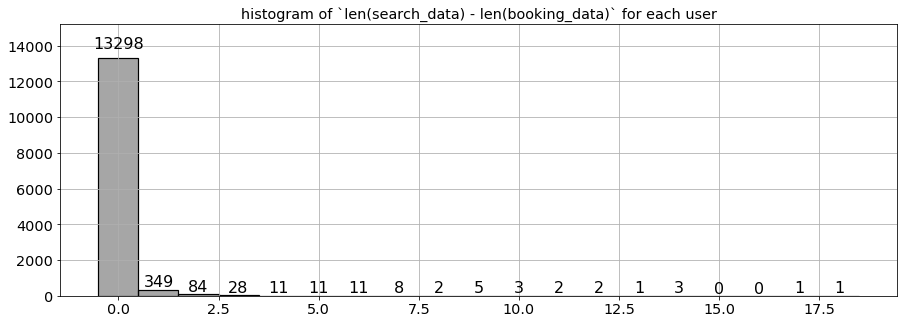

In [21]:
start = time.time()
diff = np.array([],np.int64)
i = 0

print('\nuID                         len(search_data)-len(booking_data)\n' + 
      '----------------------------------------------------------------')
for uID,idx in uID_to_search.items():
    diff = np.append(diff,(len(search_data.loc[idx]) - len(booking_data[booking_data['booking_user_id']== uID])))
    i = i + 1
#     if 25 < i < 55:
#         # print only first 20 for viewing purposes
#         print('{}      {}'.format(uID[:20] +'...',  diff[-1]))
    

def autolabel(rects, ax):
    """
    Attach a text label above each bar displaying its height
    """
    
    heights = []
    for rect in rects:
        heights.append(rect.get_height())

    e1, e2 = plt.ylim()
    plt.ylim((e1, e2*1.09))
    
    for i, rect in enumerate(rects):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.03*height, \
            '%d' % heights[i], ha='center', va='bottom', fontsize=16)
        
    
fig, ax = plotter()
heights, left, _ = ax.hist(diff, bins=np.arange(20), edgecolor='black', lw=1.2, 
         fc=(0, 0, 0, 0.35));
plt.close('all')

fig, ax = plotter(title='histogram of `len(search_data) - len(booking_data)` for each user')
rects = ax.bar(left[:-1], heights, width=1,  edgecolor='black', lw=1.2, 
         fc=(0, 0, 0, 0.35));

autolabel(rects, ax=ax);

print_runtime()


> * It's noted that `96%` of all bookings have only a single search record.

In [24]:
# create "booked?" column in 'search_data'
start = time.time()
index_of_booked_ = []
for uID, idx in uID_to_search.items():
    for sessID in set(booking_data[booking_data['booking_user_id'] == uID]['session_id']):
        for idx_b in booking_data[booking_data['booking_user_id'] == uID].index:
            for idx_s in idx:
                cols1 = ['booking_user_id', 'session_id', 'origin','destination']
                cols2 = ['search_user_id', 'session_id', 'origin','destination']
                eq1 = booking_data.loc[idx_b, cols1]
                eq2 = search_data.loc[idx_s, cols2]

                boolean = [item[0] == item[1] for item in zip(eq1,eq2)]
                if all(boolean): 
                    index_of_booked_.append(idx_s)

search_data.loc[set(index_of_booked_),'booked?'] = 1
print(sum(search_data['booked?'] == 1))
print_runtime()

15544
Runtime: 1 min 53 sec


> * Choose features from `search_data` and load them into `X` and `y` arrays.

> ### Feature Scaling

In [75]:
# RANDOM FOREST and FEED FORWARD NETWORK 
# FEATURE SCALING
features = ['distance_n', 'fare_USD_n', 'cabin_class_ECONOMY', 'num_requests', 'departure_hour']

# Use X and y in the FFN model as well.
X = search_data[features].values
y = search_data['booked?'].values

# normalize input vector X
for i in range(X.shape[1]):
    m, s = np.mean(X[:,i]), np.std(X[:,i])
    X[:,i] = (X[:,i] - m)/s


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
# Further split the class-equalized (X_train,y_train) into 80% (X_train, y_train), 20% (X_cv,y_cv).
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

def bootstrap_data(X_train, y_train, factor=2):
    # Oversample the positive class with bootstrapping on the training dataset.
    # minority class is labeled 1.
    positive_idx = np.where(y_train == 1)[0]
    bootstrap = np.random.choice(positive_idx, len(y_train[y_train == 0])//factor - len(y_train[y_train == 1]))

    bootstrap_X = X_train[bootstrap]
    bootstrap_y = y_train[bootstrap]

    X_train = np.concatenate((X_train,bootstrap_X))
    y_train = np.concatenate((y_train,bootstrap_y))
    
    return X_train, y_train

X_train, y_train = bootstrap_data(X_train, y_train, factor=2)
X_cv, y_cv = bootstrap_data(X_cv, y_cv, factor=2)

# -----------------------------------------------

print('Class imbalance: %3.0f%% out of 100%%\n' % (100*len(y_train[y_train == 1]) / len(y_train[y_train == 0])))
for i in range(X.shape[1]):
    m, s = np.mean(X[:,i]), np.std(X[:,i])
    print('X columns mean = %5.3f stdevs = %5.3f' % (m,s))


Class imbalance:  50% out of 100%

X columns mean = -0.000 stdevs = 1.000
X columns mean = 0.000 stdevs = 1.000
X columns mean = -0.000 stdevs = 1.000
X columns mean = 0.000 stdevs = 1.000
X columns mean = 0.000 stdevs = 1.000


> ### Training the Random Forest Classifier

In [76]:
# define some helper functions. 

def threshold_rounder(y_pred_test, threshold=0.5):
    y_pred_test_01 = np.zeros_like(y_pred_test)
    y_pred_test_01[y_pred_test > threshold] = 1
    y_pred_test_01[y_pred_test < threshold] = 0

    return y_pred_test_01

def confusion_matrix(y_true, y_pred):
    a = y_pred[y_true == 1]
    b = y_pred[y_true == 0]
    
    tp = sum(a)
    fp = sum(b)
    tn = len(b) - sum(b)
    fn = len(a) - sum(a)
    
    accuracy  = (tp+tn)/ float(tp+tn+fp+fn)
    recall    = tp/float(tp+fn)
    precision = tp/float(tp+fp)
    f1_score  = 2*precision*recall/float(precision + recall)
    fpr = fp/(fp+tn)
    
    return accuracy, precision, recall, f1_score, fpr
#........................................................

In [77]:
start = time.time()
clf = RandomForestClassifier(max_depth=5,n_estimators=2)
clf.fit(X_train, y_train)

# -----------------------------------------------
y_pred_train = clf.predict(X_train)
y_pred_cv = clf.predict(X_cv)
y_pred_test = clf.predict(X_test)

((_,precision_train),(_,recall_train),(_,f1_score_train),_) = prf_score(y_true=y_train, y_pred=y_pred_train)
((_,precision_cv), (_,recall_cv), (_,f1_score_cv),_)  = prf_score(y_true=y_cv,  y_pred=y_pred_cv)
((_,precision_test), (_,recall_test), (_,f1_score_test),_)  = prf_score(y_true=y_test,  y_pred=y_pred_test)

print("Training set:")
print("\tprecision: %5.3f" % precision_train)
print("\trecall:    %5.3f" % recall_train)
print("\tf1_score:  %5.3f" % f1_score_train)
print("\nTest set:")
print("\tprecision: %5.3f" % precision_test)
print("\trecall:    %5.3f" % recall_test)
print("\tf1_score:  %5.3f" % f1_score_test)
print_runtime()

Training set:
	precision: 0.955
	recall:    0.945
	f1_score:  0.950

Test set:
	precision: 0.339
	recall:    0.949
	f1_score:  0.500
Runtime: 0 min 1 sec


--- 
```javascript
                                                                      Test set, max_depth = 2:
                                                                      	precision: 0.348
                                                                      	recall: 0.947
                                                                      	f1_score: 0.509```

```javascript
                                                                      Test set, max_depth = 5:
                                                                      	precision: 0.345
                                                                      	recall:    0.947
                                                                      	f1_score:  0.506

```

> * Print the feature importances.

In [37]:
# print('')
# ind = np.argsort(clf.feature_importances_)
# ind = np.flip(ind, axis=0)
# for i in ind:
#     print('%s,    importance_: %5.3f' % (features[i], clf.feature_importances_[i]))



### METHODOLOGY

> * the user IDs `search_user_id` and `'booking_user_id` columns in `search_data.csv` and `booking_data.csv` have been matched to find the records of customers who purchased tickets on the `search_data.csv`. This enabled to identify the rows in `search_data.csv` that resulted in flight bookings.


> * Because of the presence of categorical featires and numerical features, Random Forest Classifier is chosen to make a baseline model. The `search_data.csv` dataset is solely used to train the classifier. all the search events that resulted in a booking is labeled as a positive class datapoint, and the rest negative class.


> * The ratio of the sizes of the positive to negative classes is 1.2%. The effect of imbalance between positive and negative classes have been alleviated by oversampling the positive class data points with replacement until the size ratio reached 1-to-2. 

### RESULTS

> * The features `num_requests`, `fare_USD`, and `flight distance` have the most predictive power in the classifier model.

> * Without bootstrapping the accuracy metric on the test set was:

> `Test set:`   
>  	`    precision: 0.466`  
> 	`    recall: 0.291`  
>	`    f1_score: 0.359`  

> * With oversampling the positive class with replacement the accuracy metric on the test set is:

> `Test set:`   
>  	`    precision: 0.438`  
> 	`    recall: 0.432`  
>	`    f1_score: 0.435`  



---

> # PART 2-a    FEED FORWARD NEURAL NETWORK MODEL

In [78]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
#........................................................


import matplotlib.pylab as pylab
import time
from matplotlib.ticker import MaxNLocator
from keras.callbacks import Callback
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (17, 3),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}
pylab.rcParams.update(params)

        
class Callback_Func(Callback):
    def __init__(self, train_data, test_data, start, wanna_plot=True):
        self.train_data = train_data
        self.test_data = test_data
        self.loss_train = []
        self.loss_test = []
        self.acc = []
        self.start = start
        self.wanna_plot = wanna_plot
        
    def plotter(self, title='validation accuracy'):
        ax = plt.subplot(121)
        plt.xlabel('epochs')
        plt.grid('on')
        plt.title('loss')
        x_plot = range(1, len(self.loss_train)+1)
        plt.xlim((1,max(max(x_plot),2)))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.plot(x_plot, self.loss_test, 'r--^', alpha=.7, label="validation")
        ax.plot(x_plot, self.loss_train, 'k--^', alpha=.7, label="train")
        plt.legend()

        ax = plt.subplot(122)
        plt.xlabel('epochs')
        plt.grid('on')
        ax.plot(x_plot, self.acc, 'b--^', alpha=.5)
        plt.xlim((1,max(max(x_plot),2)))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.title(title)
        plt.ion()
        plt.show()


    def on_epoch_end(self, epoch, logs={}):
        X_train, y_train = self.train_data
        X_test, y_test = self.test_data
        _loss_train, _ = self.model.evaluate(X_train, y_train, verbose=0)
        _loss_test, _acc = self.model.evaluate(X_test, y_test, verbose=0)
        self.loss_train.append(_loss_train)
        self.loss_test.append(_loss_test)
        self.acc.append(_acc)
        
        end = time.time()
        print('\nRuntime: %d min %d sec' % ((end-start)//60, (end-start)%60))
        
        if self.wanna_plot: self.plotter()
        
#........................................................

In [79]:
# def one_hot(y):
#     label_encoder = LabelEncoder()
#     integer_encoded = label_encoder.fit_transform(y)

#     onehot_encoder = OneHotEncoder(sparse=False)
#     integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
#     onehot_encoded = onehot_encoder.fit_transform(integer_encoded) 
#     return onehot_encoded

# y_train = one_hot(y_train)
# y_test = one_hot(y_test)
# y_cv = one_hot(y_cv)


In [80]:
model = Sequential()
model.add(Dense(512, input_shape=(5,), activation='tanh'))
# model.add(Dropout(0.2))
model.add(Dense(256, activation='tanh'))
# model.add(Dropout(0.2))
model.add(Dense(128, activation='tanh'))
# model.add(Dropout(0.2))
model.add(Dense(128, activation='tanh'))
# model.add(Dropout(0.2))
model.add(Dense(128, activation='tanh'))
# model.add(Dropout(0.2))
model.add(Dense(64, activation='tanh'))
# model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['mse'])
# print summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 512)               3072      
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_19 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total para

In [1]:
start = time.time()

#........................................................
from keras.callbacks import ModelCheckpoint  
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

callback_inst = Callback_Func((X_train, y_train),(X_cv, y_cv), 
                              time.time(), wanna_plot=True)


model.fit(X_train, y_train, 
          validation_data=(X_cv, y_cv),
          epochs=100, 
          batch_size=512, 
          callbacks=[callback_inst, checkpointer], 
          verbose=1)

#........................................................
print_runtime()

In [82]:
model.save_weights('saved_models/weights.best.from_scratch.hdf5')

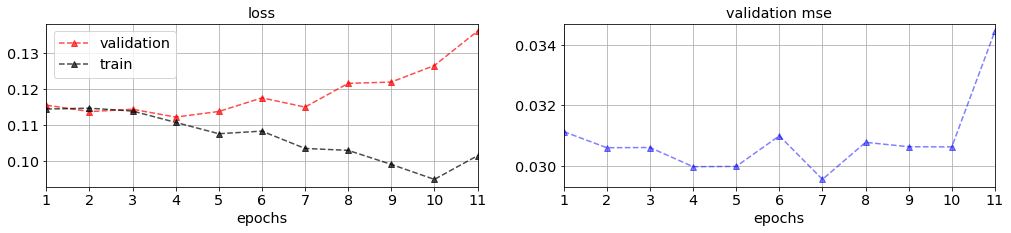

In [83]:
callback_inst.plotter('validation mse')

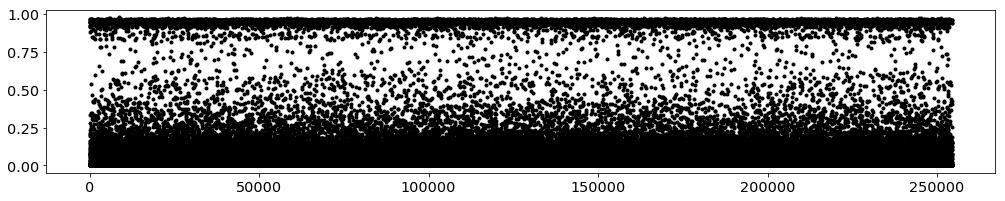

In [96]:
y_pred_test = model.predict(X_test, batch_size=1024)
plt.plot(y_pred_test,'k.');

In [85]:
start = time.time()

def return_ROC_statistics(threshold=np.linspace(0,1,51)):
    y_pred_train = model.predict(X_train, batch_size=1024)[:,0]
    y_pred_cv    = model.predict(X_cv,    batch_size=1024)[:,0]
    y_pred_test  = model.predict(X_test,  batch_size=1024)[:,0]

    rec, fpr, acc, pre = [], [], [], [] 
    if not hasattr(threshold, '__iter__'):
        threshold = [threshold]
    for t in threshold:
        y_pred_train_01 = threshold_rounder(y_pred_train, threshold=t)
        y_pred_cv_01    = threshold_rounder(y_pred_cv,    threshold=t)
        y_pred_test_01  = threshold_rounder(y_pred_test,  threshold=t)
        acc_, pre_, rec_, f1_, fpr_ = confusion_matrix(y_test, y_pred_test_01)
        acc.append(acc_)
        pre.append(pre_)
        rec.append(rec_)
        fpr.append(fpr_)
    return y_pred_train_01, y_pred_cv_01, y_pred_test_01, acc, pre, rec, fpr
#........................................................

_, _, _, acc, pre, rec, fpr = return_ROC_statistics()
y_pred_train_01, y_pred_cv_01, y_pred_test_01, _, _, _, _ = return_ROC_statistics(.5)

# report test accuracy
test_accuracy = 100.*np.sum(y_pred_test_01==y_test)/len(y_pred_test_01)
print('Test accuracy: %5.3f %%' % test_accuracy) 


((_,precision_train),(_,recall_train),(_,f1_score_train),_) = prf_score(y_true=y_train, y_pred=y_pred_train_01)
((_,precision_cv),   (_,recall_cv),   (_,f1_score_cv),_)    = prf_score(y_true=y_cv,    y_pred=y_pred_cv_01)
((_,precision_test), (_,recall_test), (_,f1_score_test),_)  = prf_score(y_true=y_test,  y_pred=y_pred_test_01)

print("Training set:")
print("\tprecision: %5.3f" % precision_train)
print("\trecall:    %5.3f" % recall_train)
print("\tf1_score:  %5.3f" % f1_score_train)
print("\nCV set:")
print("\tprecision: %5.3f" % precision_cv)
print("\trecall:    %5.3f" % recall_cv)
print("\tf1_score:  %5.3f" % f1_score_cv)
print("\nTest set:")
print("\tprecision: %5.3f" % precision_test)
print("\trecall:    %5.3f" % recall_test)
print("\tf1_score:  %5.3f" % f1_score_test)
#........................................................
print_runtime()

/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


Test accuracy: 97.413 %
Training set:
	precision: 0.949
	recall:    0.955
	f1_score:  0.952

CV set:
	precision: 0.949
	recall:    0.946
	f1_score:  0.947

Test set:
	precision: 0.311
	recall:    0.952
	f1_score:  0.469
Runtime: 0 min 56 sec


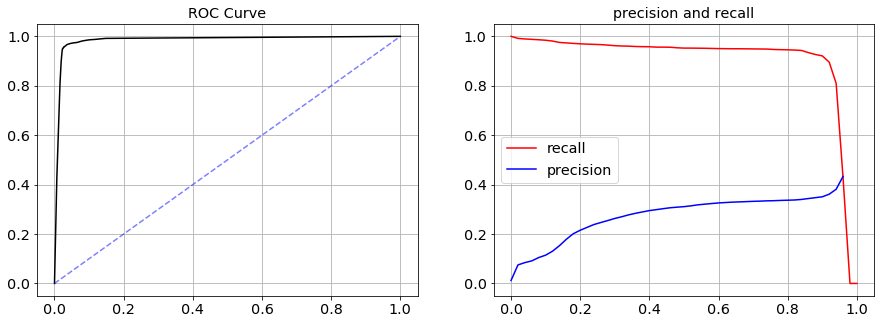

In [95]:
fig, ax = plotter(xlabel='FPR', ylabel='TPR', title='ROC Curve')
ax = plt.subplot(121)
plt.grid('on')
plt.plot(fpr, rec, 'k')
plt.plot([0,1], [0,1],'b--', alpha=.5)
plt.title('ROC Curve')


# fig, ax = plotter(xlabel='threshold', title='precision and recall')
ax = plt.subplot(122)
plt.grid('on')
threshold = np.linspace(0,1,len(pre))
plt.plot(threshold, rec, 'r')
plt.plot(threshold, pre, 'b')
plt.title('precision and recall')

ax.legend(['recall', 'precision'])
#........................................................



---
#### RECORDED RESULTS:
```
threshold = 0.85
Test set:
	precision: 0.343
	recall:    0.922
	f1_score:  0.500


threshold = 0.5
Test set:
	precision: 0.300
	recall:    0.948
	f1_score:  0.456
```

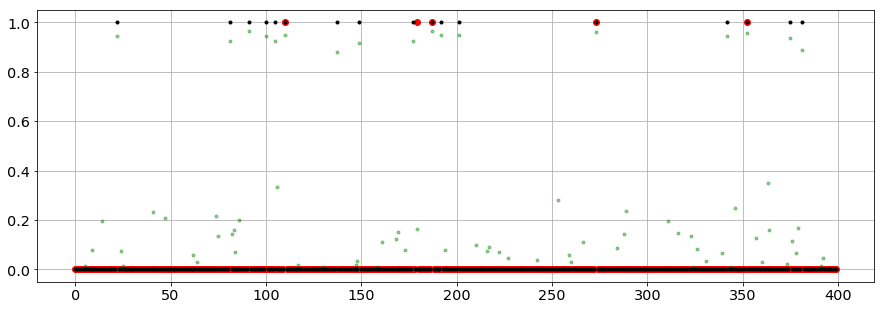

In [101]:
fig, ax = plotter() 
ax.plot(y_test[:400],'ro');
ax.plot(y_pred_test[:400],'g.',alpha=.4);
ax.plot(y_pred_test_01[:400],'k.');


In [431]:
y_pred_test_01.shape

(254387, 1)

---